In [1]:
%load_ext autoreload
%autoreload 2
from targets.density_estimation_target import *

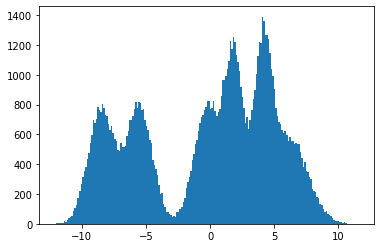

In [2]:
target = Dimension1()
data = target.sample(100000)
fig = plt.hist(data.numpy(), bins = 200)
plt.show()

In [3]:
from models_dif import DIFDensityEstimator
from models import NDRE
architecture = DIFDensityEstimator
structure = 10
from prettytable import PrettyTable

from functools import lru_cache
import time

@lru_cache(maxsize = None)
def count_parameters(structure):
    model = architecture(data, structure)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters(structure)
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     10     |
|  w.f.0.bias  |     10     |
|     T.m      |     10     |
|   T.log_s    |     10     |
+--------------+------------+
Total Trainable Params: 40
40


In [4]:
import copy 
def metropolis_adjusted_langevin_step(current_model,data,tau):
    
    #evaluate current model
    current_model.zero_grad()
    log_prob = -current_model.loss(data)*data.shape[0]
    log_prob.backward()
    print(log_prob)
    
    #copy model
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(data)*data.shape[0]
    copy_log_prob.backward()
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        print(torch.exp(acceptance_log_prob))
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            return copy_model
        else:
            print('denied')
            return current_model

    return copy_model


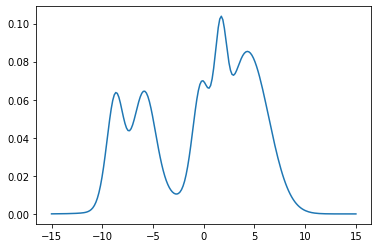

tensor(-285312.5000, grad_fn=<MulBackward0>)
tensor(-285308.1250, grad_fn=<MulBackward0>)
tensor(0.8224)
accepted


In [ ]:
from IPython.display import clear_output
linspace = torch.linspace(-15.,15., 200)

current_model = DIFDensityEstimator(data, structure)
log_prob = -current_model.loss(data)*data.shape[0]
log_prob.backward()

tau = 1/data.shape[0]
for i in range(20000):
    clear_output(wait = True)
    plt.figure()
    sum_density = torch.exp(current_model.log_density(linspace.unsqueeze(-1)))
    plt.plot(linspace, sum_density.detach().numpy())
    plt.show()
         
    #copy model
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(data)*data.shape[0]
    copy_log_prob.backward()
    print(log_prob)
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        print(torch.exp(acceptance_log_prob))
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            current_model = copy_model
            log_prob = copy_log_prob
    